# **NLP Project** **...ChatBot** **....By Muhammad Ali**
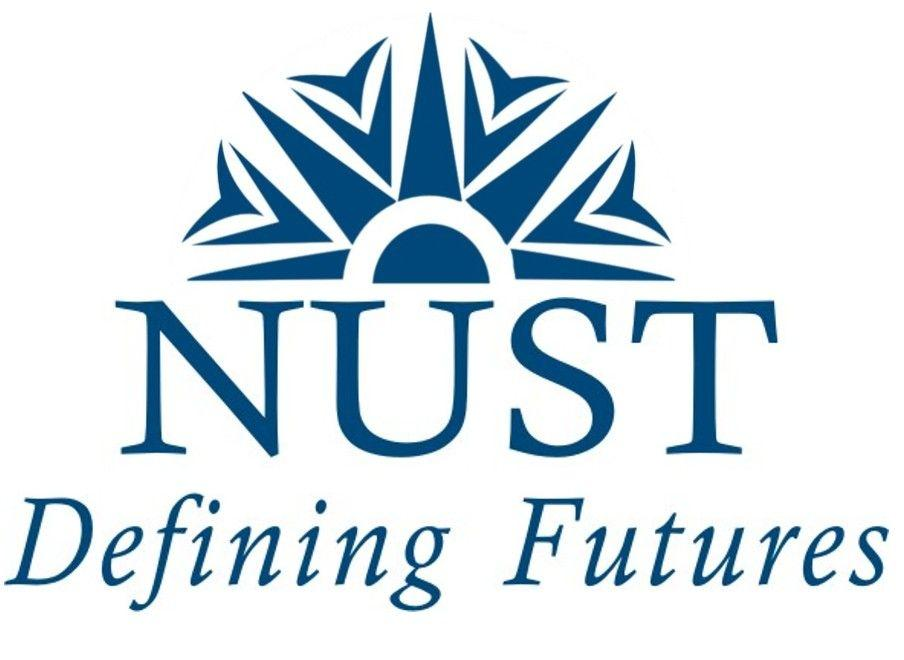






---



**Important Imports**

In [47]:
import nltk
import json
import random
import pickle
import numpy as np
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import logging
import sys
import os

**Download NLTK resources**

In [35]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Load Data from JSON File**

In [36]:
with open("/content/drive/MyDrive/train_freq.json", "r") as f:
    intents = json.load(f)

**Preprocess Data**

In [37]:
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

lemmatizer = WordNetLemmatizer()

for intent in intents['intents']:
    for pattern in intent['text']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['intent']))
        if intent['intent'] not in classes:
            classes.append(intent['intent'])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

**Load Data From NLTK**

In [38]:
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

**Create Training Data**

In [39]:
training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]

    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training)

train_x = list(training[:, 0])
train_y = list(training[:, 1])


<ipython-input-39-efc9736a0dde>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


**Build and Train the Neural Network Model**

In [40]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

**Use the Legacy SGD Optimizer**

In [41]:
# Compile your model
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Training loop
epochs = 200
batch_size = 5
verbose = 1  # Set verbose to 1 to see training progress

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train the model for one epoch
    hist = model.fit(np.array(train_x), np.array(train_y), batch_size=batch_size, verbose=verbose)

    # Print the loss and accuracy for this epoch
    print(f"Loss: {hist.history['loss'][0]}, Accuracy: {hist.history['accuracy'][0]}")

# Save the trained model
model.save('chatbot_model_by_Ali.h5')

print('Model training completed.')

Epoch 1/200
29/29 [==============================] - 0s 1ms/step - loss: 3.1389 - accuracy: 0.0490
Loss: 3.1388940811157227, Accuracy: 0.04895104840397835
Epoch 2/200
29/29 [==============================] - 0s 1ms/step - loss: 3.0103 - accuracy: 0.0979
Loss: 3.010308027267456, Accuracy: 0.0979020968079567
Epoch 3/200
29/29 [==============================] - 0s 1ms/step - loss: 2.8747 - accuracy: 0.2098
Loss: 2.874689817428589, Accuracy: 0.2097902148962021
Epoch 4/200
29/29 [==============================] - 0s 1ms/step - loss: 2.7513 - accuracy: 0.2308
Loss: 2.7512500286102295, Accuracy: 0.23076923191547394
Epoch 5/200
29/29 [==============================] - 0s 1ms/step - loss: 2.5529 - accuracy: 0.2937
Loss: 2.55289626121521, Accuracy: 0.2937062978744507
Epoch 6/200
29/29 [==============================] - 0s 1ms/step - loss: 2.3354 - accuracy: 0.3357
Loss: 2.335364818572998, Accuracy: 0.3356643319129944
Epoch 7/200
29/29 [==============================] - 0s 1ms/step - loss: 2.0660

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Load the Trained Model and other Resources**

In [42]:
intents = json.loads(open('/content/drive/MyDrive/train_freq.json').read())
words = pickle.load(open('words.pkl', 'rb'))
classes = pickle.load(open('classes.pkl', 'rb'))
model = tf.keras.models.load_model('chatbot_model_by_Ali.h5')

**Define Functions for Message Processing and Response Generation**

In [43]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

In [44]:
def bag_of_words(sentence):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
    return np.array(bag)

In [45]:
def predict_class(sentence):
    bow = bag_of_words(sentence)
    res = model.predict(np.array([bow]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

In [46]:
def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['intent'] == tag:
            result = random.choice(i['responses'])
            break
    return result

**Chat Loop**

In [48]:

# Configure TensorFlow to suppress training progress output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Create a function to temporarily redirect stdout
class RedirectStdout:
    def __init__(self, new_target):
        self.new_target = new_target
        self.old_target = None

    def __enter__(self):
        self.old_target = sys.stdout
        sys.stdout = self.new_target

    def __exit__(self, *args):
        sys.stdout = self.old_target

print("GO! Bot is running! Type 'exit' to close the Chatbot.")

while True:
    message = input("You: ")
    if message.lower() == 'exit':
        print('Bot: Bye, see you again! : Dont Forget to Visit My GitHub : https://github.com/Muhammad-Ali-56')
        break
    else:
        # Temporarily suppress TensorFlow training progress output
        with RedirectStdout(open(os.devnull, 'w')):
            ints = predict_class(message)
            res = get_response(ints, intents)

        print(f'Bot: {res}')




GO! Bot is running! Type 'exit' to close the Chatbot.
You: hello
Bot: Hello human, please tell me your Friend user
You: what is your name
Bot: Call me Friend
You: what is your real name
Bot: I am an AI Model and My Developers Name is Ali
You: thanks
Bot: Happy to help!
You: thank you
Bot: Happy to help!
You: exit
Bot: Bye, see you again! : Dont Forget to Visit My GitHub : https://github.com/Muhammad-Ali-56


**End**